In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import random as r
from math import *
from numpy import linalg as LA

# 1. Algorithme

In [2]:
Petersen = nx.petersen_graph()
C6 = nx.cycle_graph(6)
Biparti34 = nx.complete_bipartite_graph(3,4)

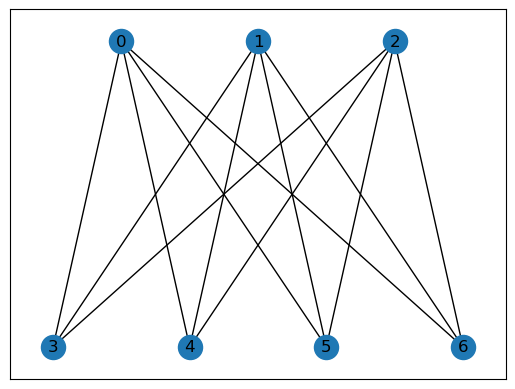

In [3]:
pos_bip34 = {0 : [-1,1], 1 : [0,1], 2 : [1, 1], 3 : [-1.5, -1], 4 : [-0.5, -1], 5 : [0.5, -1], 6 : [1.5, -1]}
nx.draw_networkx(Biparti34,pos = pos_bip34)

## 1.1 Preprocessing

In [1]:
def Dijkstra_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au Dijkstra à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred,dist = nx.dijkstra_predecessor_and_distance(G,source)
    return pred,dist


def inverse_dist(dist):
    """Prend le dictionnaire des distance et renvoie un dictionnaire où inv[d] = [liste des à distance d]"""
    inverse = {}
    for noeud,distance in dist.items():
        inverse.setdefault(distance, []).append(noeud)
    return inverse


def Table_PCC(pred,dist,source):
    """Prend en argument le couple (DAG des predecesseurs,dictionnaire des distance) dans Dijsktra qui part de source. Renvoie un tableau avec en position i le nombre de plus court chemins qui partent de la source et arrivent en i"""
    n = len(pred)
    table = np.zeros(n)

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme
    return table

In [14]:
pred, dist = Dijkstra_DAG(Biparti34,0)
pred

{0: [], 3: [0], 4: [0], 5: [0], 6: [0], 1: [3, 4, 5, 6], 2: [3, 4, 5, 6]}

In [15]:
tab = Table_PCC(pred,dist,0)
tab

array([1., 4., 4., 1., 1., 1., 1.])

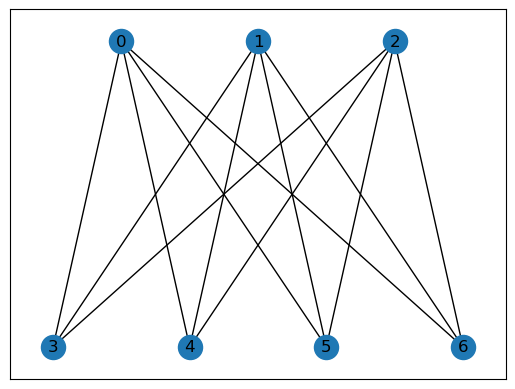

In [16]:
#nx.draw_networkx(C6)
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [2]:
def Table_PCC_In_Place(pred,dist,source,table):
    """Même fonction que Table_PCC mais en remplissant la table passée en argument (supposée de la bonne taille)"""

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme


def Preprocessing_Graph(G):
    """ Renvoie un tuple (dags,tables,table_departs,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins partant de i et arrivant à j
        - table_departs[i] = nombre de plus court chemins partant du noeud i
        - nb_chemins = nombre total de plus courts chemins dans le graphe """

    n = len(G)

    dags = []
    tables = np.zeros((n,n))

    for source in range(n):
        pred,dist = Dijkstra_DAG(G,source)
        dags.append(pred)
        Table_PCC_In_Place(pred,dist,source,tables[source])

    table_departs = np.sum(tables,axis = 1)                                        #nb_chemins[depart] = nb de PCC qui partent de depart
    nb_chemins = np.sum(table_departs)

    return (dags,tables,table_departs,int(nb_chemins))

In [18]:
prep = Preprocessing_Graph(Biparti34)
prep[1]

array([[1., 4., 4., 1., 1., 1., 1.],
       [4., 1., 4., 1., 1., 1., 1.],
       [4., 4., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 3., 3., 3.],
       [1., 1., 1., 3., 1., 3., 3.],
       [1., 1., 1., 3., 3., 1., 3.],
       [1., 1., 1., 3., 3., 3., 1.]])

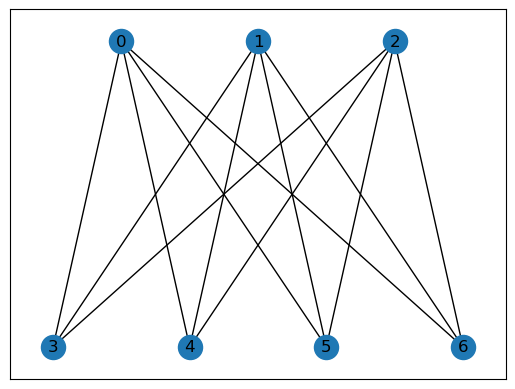

In [19]:
nx.draw_networkx(Biparti34,pos = pos_bip34)

## 1.2 Requêtes

In [3]:
def Unranking_PCC_depart_arrivee(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    dags,tables,table_departs,nb_chemins = preprocessing

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]

        chemin.append(pred_courant)
        noeud_courant = pred_courant

    chemin.reverse()
    return chemin

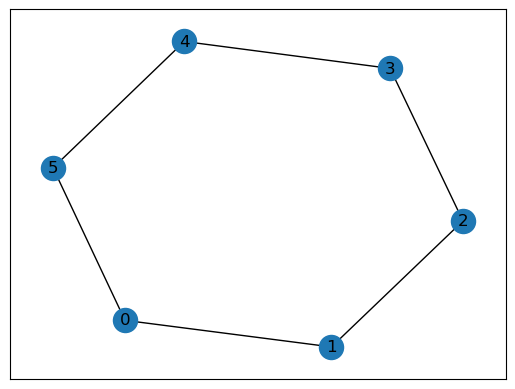

In [22]:
prep = Preprocessing_Graph(C6)
nx.draw_networkx(C6)

In [24]:
l = [Unranking_PCC_depart_arrivee(prep,0,3,r) for r in range(5)]
l

[[0, 1, 2, 3], [0, 5, 4, 3], [0, 1, 2, 3], [0, 5, 4, 3], [0, 1, 2, 3]]

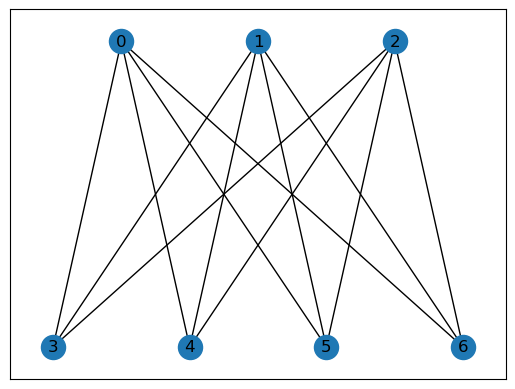

In [25]:
prep = Preprocessing_Graph(Biparti34)
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [26]:
l = [Unranking_PCC_depart_arrivee(prep,0,1,r) for r in range(5)]
l

[[0, 3, 1], [0, 4, 1], [0, 5, 1], [0, 6, 1], [0, 3, 1]]

In [4]:
def Unranking_PCC_depart(preprocessing, depart, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin partant de départ de rang 'rang' """

    dags,tables,table_departs,nb_chemins = preprocessing
    table_travail = tables[depart]

    rang_reduit = rang % table_departs[depart]


    # On trouve le noeud d'arrivée
    arrivee_courante = 0
    while (rang_reduit >= table_travail[arrivee_courante]):
        rang_reduit = rang_reduit - table_travail[arrivee_courante]
        arrivee_courante += 1

    return Unranking_PCC_depart_arrivee(preprocessing,depart,arrivee_courante,rang_reduit)

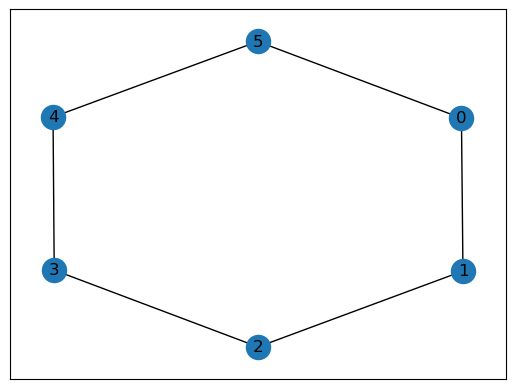

In [29]:
prep = Preprocessing_Graph(C6)
nx.draw_networkx(C6)

In [30]:
l = [Unranking_PCC_depart(prep,0,r) for r in range(5)]
l

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 5, 4, 3]]

In [13]:
def Unranking_PCC(preprocessing,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de rang 'rang' """
    dags,tables,table_departs,nb_chemins = preprocessing


    rang_reduit = rang % nb_chemins

    # On trouve le noeud de départ
    depart_courant = 0
    while (rang_reduit >= table_departs[depart_courant]):
        rang_reduit = rang_reduit - table_departs[depart_courant]
        depart_courant += 1

    return Unranking_PCC_depart(preprocessing,depart_courant,rang_reduit)



def Uniforme_PCC(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    dags,tables,table_departs,nb_chemins = preprocessing
    rang = r.randint(0,nb_chemins-1)

    return Unranking_PCC(preprocessing,rang)

In [35]:
[r.randint(0,1) for i in range(15)]

[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]

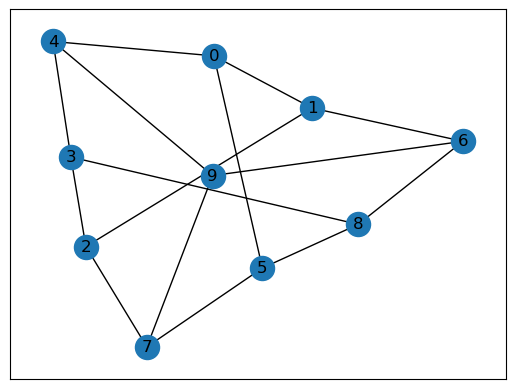

In [36]:
prep = Preprocessing_Graph(Petersen)
nx.draw_networkx(Petersen)

In [37]:
[Uniforme_PCC(prep) for i in range(5)]

[[0, 4, 3], [6, 9, 4], [5, 7, 2], [5, 0, 1], [1, 6, 8]]

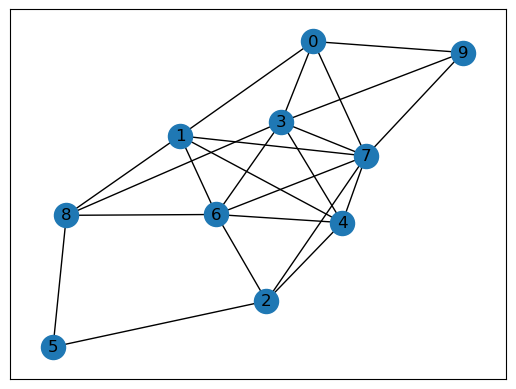

In [41]:
G = nx.erdos_renyi_graph(10,0.4)
prep = Preprocessing_Graph(G)
nx.draw_networkx(G)

In [39]:
[Uniforme_PCC(prep) for i in range(5)]

[[1, 5], [1, 0], [1, 0, 2], [7, 1, 0], [5, 2, 4]]

# 2. Complexité

## 2.1. Complexité théorique

Preprocessing : $n * (Dijktra + Table) = n*((n+m) \log(n) + (n+m)) = n(n+m)\log(n)$

Requête : $n + m$ (au pire on parcourt tout le DAG)

En mémoire le preprocessing nous demande de stocker une matrice symétrique $n*n$ et les n DAG issus des Dijkstra qui sont chacun de taille au plus $n + m$.

## 2.2. Mesures

In [7]:
def complexite_temps_donnees_erdos_renyi(c = 3, nb_noeuds = [floor(x) for x in np.logspace(1,2,50)], tailleEchantillon = 3, nbRequetes = 5):
    """ Calcule les performances temporelles du preprocessing et des requetes pour des graphes aléatoires d'Erdos-Renyi."""

    donnees_prep = []
    donnees_gen = []

    for n in nb_noeuds:

        # Création de l'échantillon
        echantillon = []
        for i in range(tailleEchantillon):
            echantillon.append(nx.erdos_renyi_graph(n,c/n))

        # Mesure des performances de preprocessing et de Unranking
        moyenne_prep = 0
        moyenne_gen = 0

        for G in echantillon:
            avant = time.time(); prep = Preprocessing_Graph(G); apres = time.time()
            moyenne_prep += (apres - avant)/tailleEchantillon

            for i in range(nbRequetes):
                avant = time.time(); pcc = Uniforme_PCC(prep); apres = time.time()
                moyenne_gen += (apres - avant)/(nbRequetes*tailleEchantillon)

        donnees_prep.append(moyenne_prep)
        donnees_gen.append(moyenne_gen)
    return (nb_noeuds,donnees_prep,donnees_gen)



def complexite_temps_donnees_geometrique(densite = 1, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)], tailleEchantillon = 3, nbRequetes = 5):
    """ Calcule les performances temporelles du preprocessing et des requetes pour des graphes aléatoires géométriques 2D. densité = n*4/3*pi*r^3"""

    donnees_prep = []
    donnees_gen = []

    for n in nb_noeuds:

        # Création de l'échantillon
        echantillon = []
        for i in range(tailleEchantillon):
            echantillon.append(nx.random_geometric_graph(n,pow(3*densite/(n*pi*4),1/3)))

        # Mesure des performances de preprocessing et de Unranking
        moyenne_prep = 0
        moyenne_gen = 0

        for G in echantillon:
            avant = time.time(); prep = Preprocessing_Graph(G); apres = time.time()
            moyenne_prep += (apres - avant)/tailleEchantillon

            for i in range(nbRequetes):
                avant = time.time(); pcc = Uniforme_PCC(prep); apres = time.time()
                moyenne_gen += (apres - avant)/(nbRequetes*tailleEchantillon)

        donnees_prep.append(moyenne_prep)
        donnees_gen.append(moyenne_gen)
    return (nb_noeuds,donnees_prep,donnees_gen)

In [8]:
def complexite_temps_graphe(donnees,logScale = False):
    nb_noeuds,donnees_prep,donnees_gen = donnees

    plt.clf()
    if logScale:
        plt.xscale("log") ; plt.yscale("log")
        
    plt.plot(nb_noeuds,donnees_prep, color = "green", label = "Preprocessing")
    plt.plot(nb_noeuds,donnees_gen, color = "red", label = "Generateur")
    plt.legend()
    plt.show()

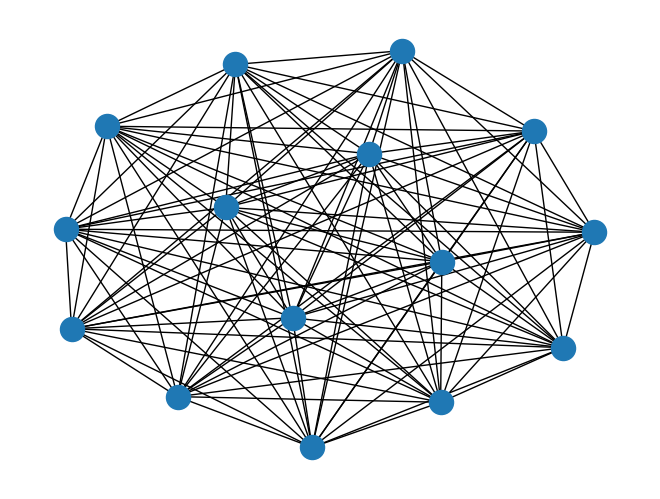

In [44]:
G = nx.erdos_renyi_graph(15,1)
nx.draw(G)

In [45]:
donnees_erdos = complexite_temps_donnees_erdos_renyi(c = 1, nb_noeuds = [floor(x) for x in np.logspace(1,3,50)])

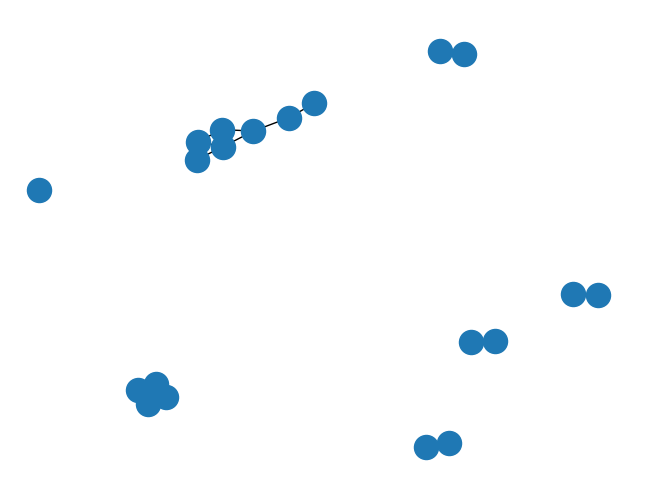

In [47]:
densite = 1
n = 20
G = nx.random_geometric_graph(n,pow(3*densite/(n*pi*4),1/3))
nx.draw(G)

In [48]:
donnees_geom = complexite_temps_donnees_geometrique(densite = 1, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)])

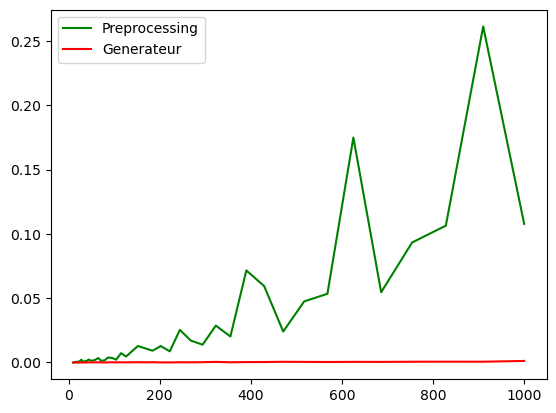

In [49]:
complexite_temps_graphe(donnees_erdos)

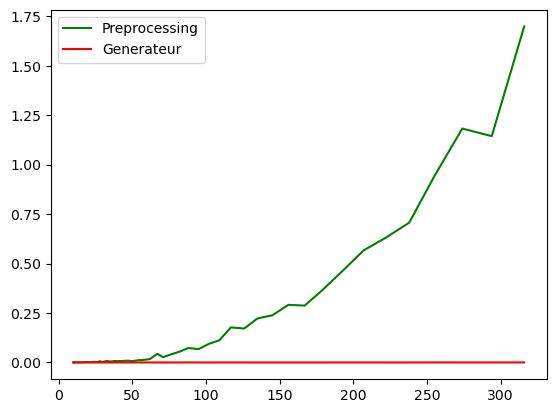

In [50]:
complexite_temps_graphe(donnees_geom)

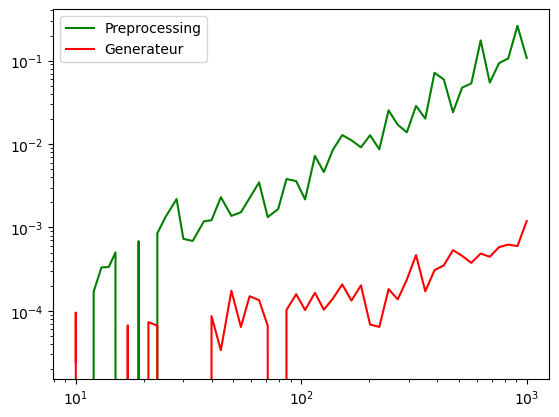

In [51]:
complexite_temps_graphe(donnees_erdos,logScale = True)

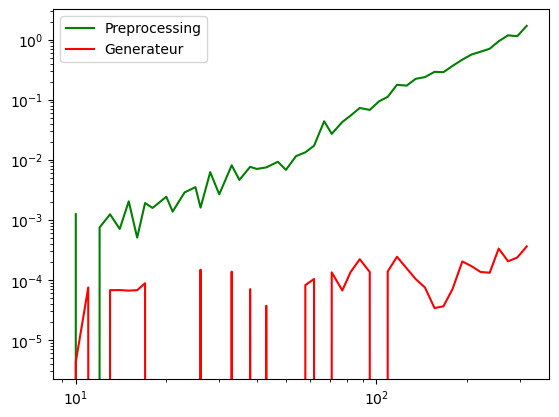

In [52]:
complexite_temps_graphe(donnees_geom,logScale = True)

## 2.3. Estimation des pentes

In [9]:
def complexite_temps_graphe_comparaison(nb_noeuds,donnees,f,logScale = True):
    
    facteur_rescaling = donnees[-1]/f(nb_noeuds[-1])
    comparaison = [facteur_rescaling*f(n) for n in nb_noeuds]

    plt.clf()
    if logScale:
        plt.xscale("log") ; plt.yscale("log")
        
    plt.plot(nb_noeuds,donnees, color = "red", label = "Donnees")
    plt.plot(nb_noeuds,comparaison, color = "blue", label = "f(n)")
    plt.legend()
    plt.show()

In [54]:
nb_noeuds_geom,donnees_geom_prep,donnees_geom_gen = donnees_geom
nb_noeuds_erdos,donnees_erdos_prep,donnees_erdos_gen = donnees_erdos

### Pour le preprocessing

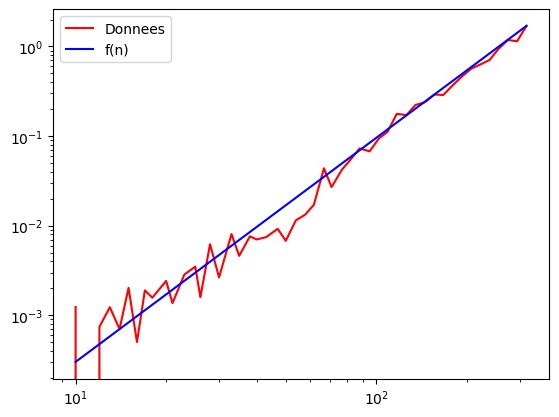

In [55]:
f = lambda x : x**(2.5)
complexite_temps_graphe_comparaison(nb_noeuds_geom,donnees_geom_prep,f)

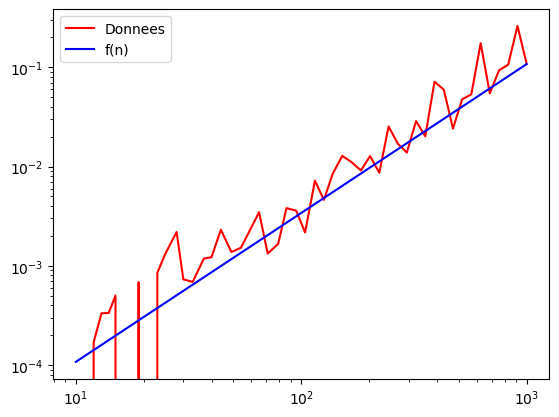

In [56]:
f = lambda x : x**(1.5)
complexite_temps_graphe_comparaison(nb_noeuds_erdos,donnees_erdos_prep,f)

### Pour le générateur

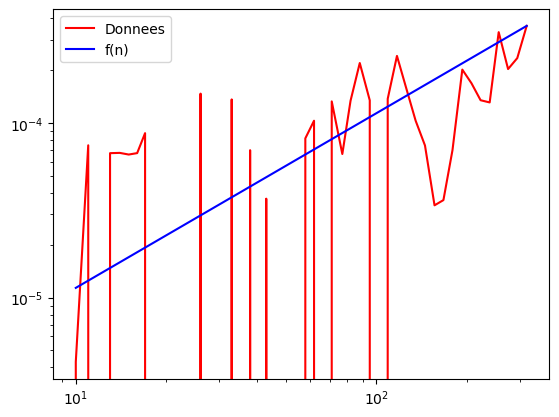

In [57]:
f = lambda x : x**(1)
complexite_temps_graphe_comparaison(nb_noeuds_geom,donnees_geom_gen,f)

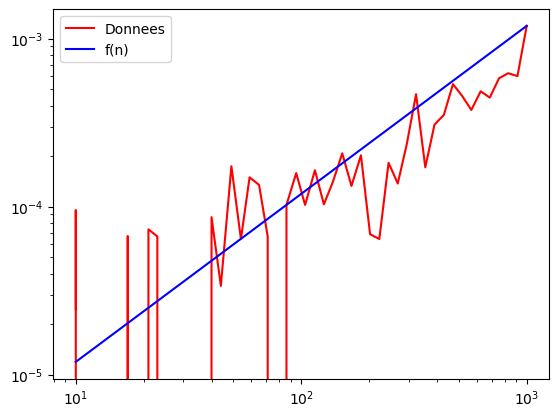

In [58]:
f = lambda x : x**(1)
complexite_temps_graphe_comparaison(nb_noeuds_erdos,donnees_erdos_gen,f)

Expérimentalement la complexité pour le preprocessing semble être en $n^\alpha$ avec $2.5 < \alpha < 3$ selon la densité du graphe.
La complexité pour la génération semble être $\underline{linéaire}$.

# 3. Graphe de ville

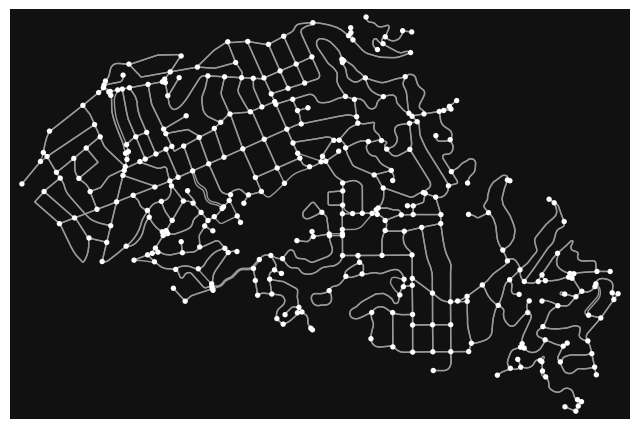

In [59]:
import osmnx as ox
%matplotlib inline
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(G))

In [60]:
G.nodes

NodeView((53017091, 53018397, 53018399, 53018402, 53018404, 53018410, 53018411, 53021742, 53021743, 53021750, 53022623, 53022625, 53023513, 53025057, 53025060, 53025220, 53025222, 53027454, 53027455, 53027457, 53027459, 53027461, 53027463, 53028190, 53028192, 53033660, 53035698, 53035699, 53036557, 53036558, 53037306, 53037307, 53040495, 53040794, 53041432, 53041437, 53041440, 53041442, 53041443, 53041445, 53041668, 53041670, 53042706, 53042707, 53044573, 53044575, 53044661, 53044664, 53046249, 53046250, 53046251, 53046252, 53046253, 53046254, 53046255, 53050874, 53050875, 53057697, 53059166, 53059173, 53059175, 53059186, 53059187, 53059189, 53059885, 53060462, 53060465, 53060466, 53060467, 53060468, 53060469, 53060471, 53060473, 53062956, 53062958, 53064300, 53064302, 53064305, 53064327, 53064328, 53064330, 53064331, 53065783, 53065785, 53066716, 53066717, 53068822, 53068826, 53068829, 53073689, 53073691, 53073816, 53073822, 53073843, 53074376, 53074377, 53074380, 53075311, 53075599, 

In [61]:
G= nx.convert_node_labels_to_integers(G)
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [62]:
prep = Preprocessing_Graph(G)

In [63]:
route = Uniforme_PCC(prep)
route

[219,
 139,
 140,
 208,
 209,
 166,
 92,
 210,
 242,
 96,
 95,
 94,
 222,
 223,
 231,
 240,
 151,
 54,
 152,
 153]

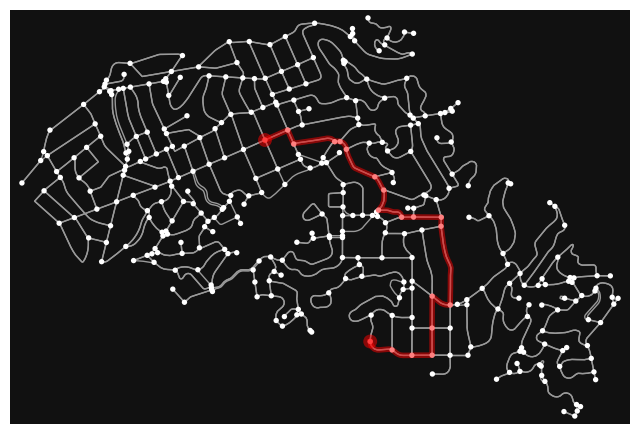

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [64]:
ox.plot_graph_route(G,route)

# 4. Comparaison avec optimisation

In [10]:
def complexite_generateur_donnees(prepG, nbRequetes = 1000):
    tailles_chemins = []
    temps_generation = []
    for i in range(nbRequetes):
        avant = time.time(); path = Uniforme_PCC(prepG); apres = time.time()
        tailles_chemins.append(len(path))
        temps_generation.append(apres-avant)
    return (tailles_chemins,temps_generation)


def complexite_generateur_points(donnees):
    tailles_chemins,temps_generation = donnees

    plt.clf()
    plt.plot(tailles_chemins,temps_generation,"ob")
    plt.show()
    

def complexite_generateur_moyennes(donnees):
    tailles_chemins,temps_generation = donnees
    tailles = {}
    temps_total = {}
    
    for i in range(len(tailles_chemins)):
        l = tailles_chemins[i]
        tailles[l] = tailles.setdefault(l, 0) + 1
        temps_total[l] = temps_total.setdefault(l,0) + temps_generation[i]
    
    longueurs = []
    temps_moyen = []
    for k in tailles.keys():
        longueurs.append(k)
        temps_moyen.append(temps_total[k]/tailles[k])

    plt.clf()
    plt.plot(longueurs,temps_moyen,"ob")
    plt.show()

In [11]:
G_reg = nx.random_regular_graph(4,1000)
prep_reg = Preprocessing_Graph(G_reg)
print(f"Nombre de plus courts chemins : {prep_reg[3]}")

Nombre de plus courts chemins : 1811304


In [14]:
donnees_reg = complexite_generateur_donnees(prep_reg,nbRequetes = 10000)

In [ ]:
complexite_generateur_points(donnees_reg)

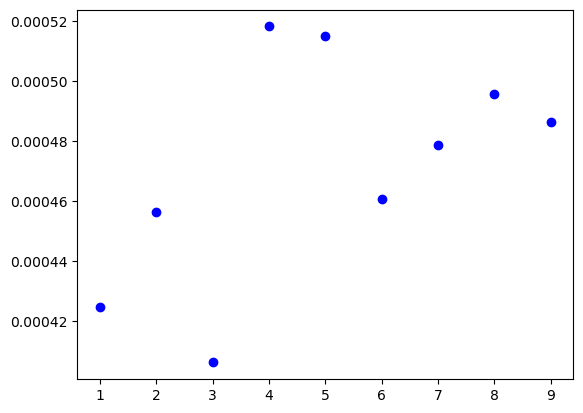

In [15]:
complexite_generateur_moyennes(donnees_reg)